# $\Sigma\Delta$ Stream Computation

$\Sigma\Delta$ Stream Computation is a strategy for implementing low complexity, low power, low latency, continuous time performance controllers / filters in digital logic. The control implementation strategy does this by directly processing high resolution, high bandwidth $\Sigma\Delta$ encoded bitstreams. Both inputs and outputs can be encoded as sigma-delta bitstreams leading to inexpensive hardware realizations. This also allows direct connection between $\Sigma\Delta$ converters and the controller hardware without need to perform parallel data conversion and thus eliminates the associated overhead and latency.

## Introduction

Applications requiring low latency and/or high bandwidth can struggle with traditional shift based filter and control design. Software based control on a micro-controller requires several thousands of processor instructions to service interrupts and perform loop iterations. At practical clock rates, the latency at which a micro-controller can sample data, process a control algorithm, and update the control output is on the scale of tens of microseconds at best. For applications that require bandwidths above tens of kilohertz, digital signal processors (DSPs) are required. Having hardware architectures that are designed for high throughput and high bandwidth computation, DSPs are able to reduce the latency of digital control implementations to hundreds of nanoseconds. The price for the reduced latency, however, is a substantial increase is component cost, as well as drastic increase in power consumption to the point where mobile (battery based) implementations are often impossible. 

For control applications requiring bandwidths of a megahertz or more, the current options are logic-based hardware control using field programmable gate arrays (FPGAs) or continuous control implemented with analog components. Applications such as micro-electro-mechanical-systems (MEMS) and atomic force microscopy require very high bandwidth controllers, due to the small device scale. FPGA programmable logic can accommodate complex controller designs that can run at hundreds of megahertz with the downside of being high cost and requiring high power consumption. Analog components on the other hand, can achieve control bandwidths of greater than hundreds of megahertz but have a litany of issues. These issues include controller hardware inflexibility, high cost, low reliability, high noise, and high sensitivity to parameter variations and drift which contribute to the complexity of such designs. All of these issues contribute to the high cost of constructing controllers for low-latency systems. This is particularly onerous for MEMS devices where the base cost could be quite low due to economies of manufacturing scale.

Presented is an alternative strategy for implementing low complexity, low power, low latency, continuous time performance controllers in digital logic. The control implementation strategy does this by directly processing high resolution, high bandwidth $\Sigma\Delta$ encoded bitstreams. Both inputs and outputs can be encoded as sigma-delta bitstreams leading to inexpensive composability and a substantial reduction of communication costs. Additionally, the potential for stable operation in adverse environments is enhanced as this representation is not place sensitive (bit-weighted) and is inherently incremental. Thus, such controllers are candidates for satellite and high reliability applications as well as extreme low power (IOT) scenarios. $\Sigma\Delta$ converters are the premier data converter for high resolution, medium bandwidth applications. They are inexpensive, exceptional linear, and produce a compact oversampled bitstream representation as their natural outputs. A method is presented of direct connection between $\Sigma\Delta$ converters and the controller hardware without need to perform parallel data conversion and thus eliminates the associated overhead and latency.

[$\Sigma\Delta$ Stream Computation](https://escholarship.org/uc/item/4f46n0h6)

## Controller Applications

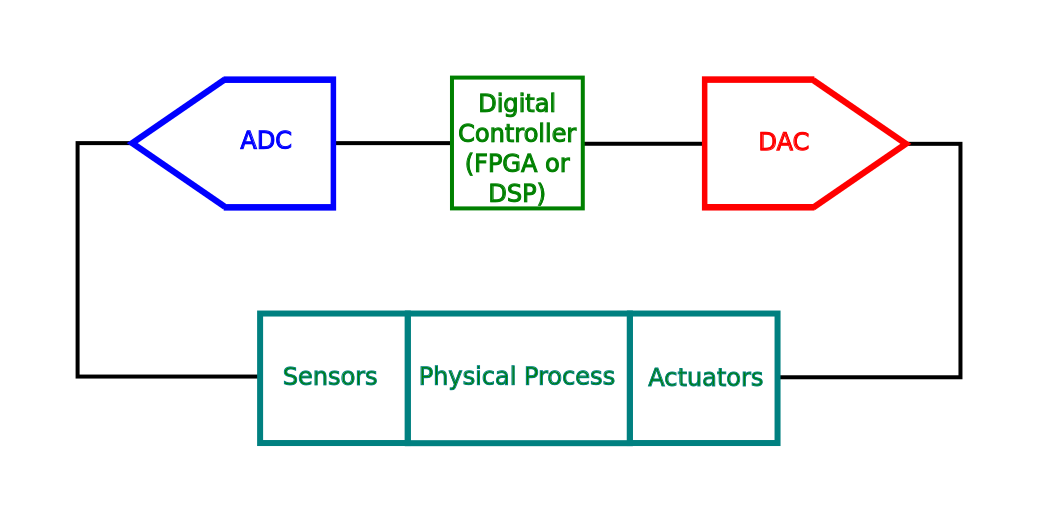

In [1]:
from IPython.display import Image
Image(filename='./Figures/Embedded_Control_Loop.png')

As shown above, the signal chain is comprised of the following components:

- Physical Process: This is the physical process that is intended to be controlled.
- Sensors/Transducers: Sensors and transducers are the components that convert a physical phenomenon (e.g. sound waves, pressure, displacement, etc.) to an electrical signal such as Voltage. These devices can range from microphones to accelerometers.
- Analog to Digital Converter (ADC): The ADC converts as electrical signal, typically a Voltage, into a series of time sampled discrete binary values.
- FPGA, DSP, $\mu$Controller: The control law in implemented discretely in a processing element such as a digital signal processor or $\mu$controller or in discrete hardware inside of an FPGA. For the DSP and $\mu$controller, the control law is written in a low level programming language such as C in order more closely manage the binary mathematics that underlie the control law.
- Digital to Analog Converter (DAC): The DAC converts a discrete binary value into an electrical signal such as a Voltage.
- Actuator: The actuator is the component that physically interacts with the outside world. These could be motors, voice coils, electromagnets, etc. and are driven by the output of the DAC.

For a general embedded control system, each component is indispensable in the implementation of the control algorithm. However, proper care must be taken by the design engineer in choosing components that will meet or exceed the required closed loop performance constraints. For example, two of the most important considerations when selecting components are that of sampling frequency and resolution. ADCs, for instance, come in several varieties that have trade-offs in sampling frequency/bandwidth and resolution. For loops that require both high resolution and high bandwidth, finding an appropriate ADC may be expensive or outright impossible given the system constraints. In these cases analog controllers are used despite their issues regarding additional noise, environmental degradation, and hardware non-flexibility. 

Currently, embedded digital control systems suffer pervasive limitations due to the digital algorithm implementation structured around processing 2's compliment signal representations at rates not far from Nyquist bounds. The reason for doing so is the intuitive simplicity of the time-shift/Z-transform model and is reinforced by the control design software (both system level and implementation) making this assumption. The ubiquity of these models and tools builds expectations of latency, complexity, and power consumption into the design methodology. Indeed, the view of many control engineers is that increasing the sampling bandwidth substantially beyond Nyquist adds complexity and expense as well as decreasing the stability of the implementation. This view is supported by classical analysis of coefficient resolution versus sampling rate, again given the time-shift implementation paradigm. In this thesis, simple controllers are implemented that exploit the inherent oversampling of the input ADC. Based on digital integrators instead of time-shift operators, the new designs offer latencies on the scale of the oversampling clock period while demonstrating enhanced stability and relaxation of coefficient resolution. (As an example, a high-order bandbass filter can be directly implemented as a single filter element in contrast to composed bi-quad elements made to accommodate coefficient sensitivity at high sample rates). A side benefit of this methodology allows the removal of all hardware multipliers from the design allowing for substantive hardware power and complexity savings, without any latency cost.  

## Why not Shift-Based LTI?

As the sampling period approaches zero, the poles of the filters converge to z=1 on the unit circle in the complex plane. In fixed point realizations where the coefficients of a filter are represented with finite precision, the possible locations of filter poles in the unit circle stability region of the Z domain become sparse in and around the real axis. The figure illustrates this effect for a fourth order lowpass filter while increasing the sample rate from 1kHz to 10kHz. As can be seen the poles and zeros converge quickly. What is more disturbing is that the black dots represent the quantization points for 5 bit coefficients in the filter.

Notice that z=1 is not a possible location within the unit circle for complex conjugate poles with distinct complex components. As sampling rates increase, discerning between distinct complex conjugate poles requires larger coefficient bitwidths leading to ever expanding logic implementations. Without, large coefficient bitwidths, the filter will experience severe filter magnitude and phase response deviations as well as the potential for instability. It seems counter intuitive that as the sample rate increases the numerical stability of the fixed point filter implementation decreases.

## Performance, Design, and Optimization of the $\Sigma\Delta$ Controller Architecture

Oversampled PDM signals provide an inexpensive encoding mechanism for time dependent signals. Direct processing strategies are described to implement high performance filters/controllers using such streams for both input and output. Despite the ubiquitous utility of Z-transform and time-shift techniques in digital filters, it will be shown that they are of little use to construct filters based on PDM representations. In particular, operations between time-shifted oversampled streams require expensive trains of delay elements (since the stream is high rate) and unfortunately have extremely poor coefficient sensitivity and stability characteristics.

Instead, controllers / filters based on integrators and direct implementation of state-space variables will be described. Since the PDM representation is binary, filter coefficient scaling is simplified to the selection of a multi-bit constant or its complement to add to the integrator input. In this way, very efficient filters can be constructed without the multiplier scaling elements that are the cornerstone of conventional digital signal processing. Given the 50 years of continual improvement in the performance of digital systems, operation at the oversampling rate is practical for such rates easily exceeding 1 GHz, leading to very high resolution filters with practical bandwidths exceeding 10MHz using these techniques. (In later chapters, we will show how to improve this to 50MHz and beyond).

While the architecture of PDM and integrator based filters has been proposed elsewhere, here we use the nature of the PDM representation and the sensitivity characteristics of the architecture to construct an optimizing algorithm minimizing the coefficient and integrator bit-widths subject to performance constraints. This minimizes the component (logic) footprint as well as the design power needed to implement the filter. Further, since the filter architecture latency is measured in small numbers of oversample periods, the filter latency is extremely low, enhancing its utility in feedback control applications.

The $\Sigma\Delta$ controller architecture will directly process bitstreams at the oversample rate and achieve near continuous time LTI control performance while having an extremely small multiplierless design that is both low power, low latency, and high resolution. In order to gauge performance, a novel quantization noise analysis and model will be presented in order to determine the output SNR of the controller logic ensemble. A metric for estimating transfer function variation due to coefficient quantization will be included as well. Using both the noise model and the transfer function variation estimate, a convex optimization scheme will be invoked in order to minimize the number of state register bits needed to construct the $\Sigma\Delta$ controller while still meeting user defined performance metrics and goals.

[$\Sigma\Delta$ Stream Computation](https://escholarship.org/uc/item/4f46n0h6)

## Gravitating Poles & Zeros
### shift Operator

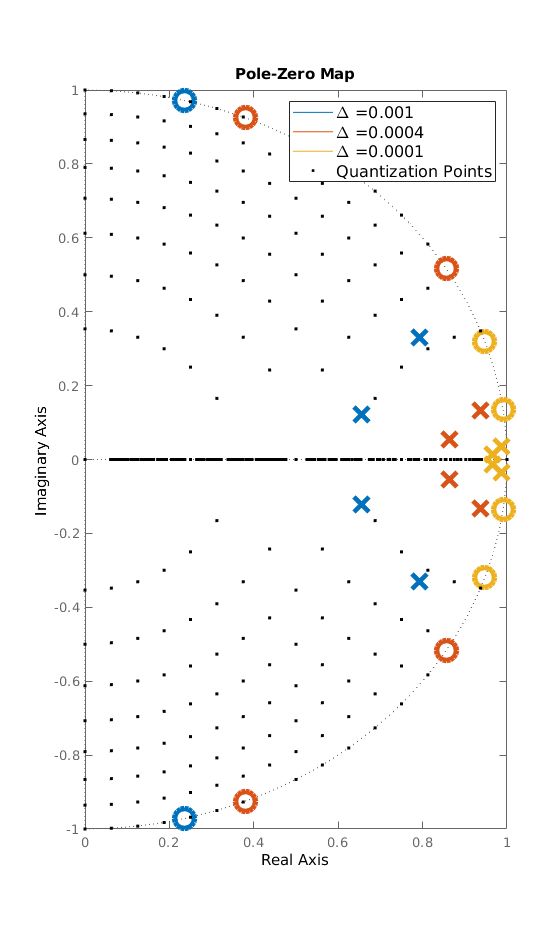

In [3]:
Image(filename='./Figures/pz_map.png')

The current paradigm in discrete filter design revolves around shift based algorithms. The shift operator $q$ can be defined as

$qx\left(k\Delta\right)=x\left(k\Delta+\Delta\right)$

The sampling zero displays very little variation with sampling rate while the poles and zeros change significantly. The poles and zeros are more heavily dependent on $\Delta$. The significant zeros and poles converge to $1 + j0$ as $\Delta$ $\rightarrow 0$ causing the system to blow up.

### $\delta$ Operator

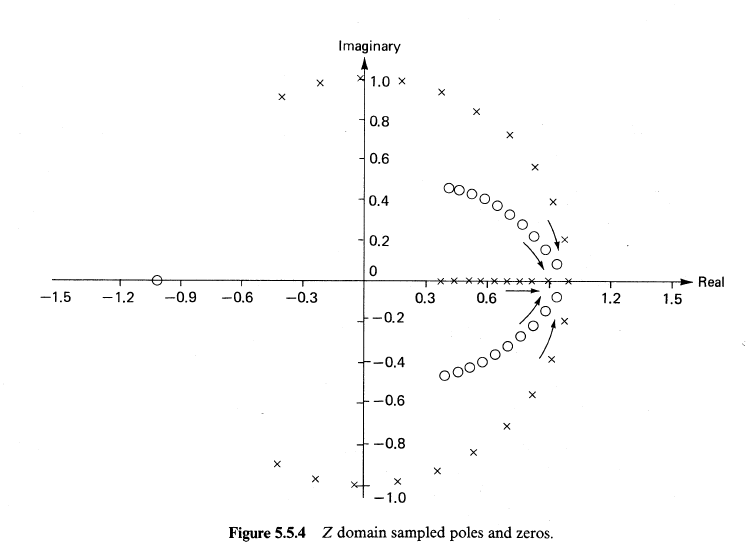

In [1]:
from IPython.display import Image
Image(filename='./Figures/z_domain_pz.png')

The $\delta$-operator is a difference based operator defined as

$\delta x\left(k\Delta\right)\triangleq\frac{x\left(k\Delta+\Delta\right)-x\left(k\Delta\right)}{\Delta}$

which is analogous to a discrete derivative approximation. Taking the limit of $\delta x\left(k\right)$ as the sampling period approaches zero we have

$\underset{\Delta\rightarrow0}{lim}\delta x\left(k\Delta\right)=\underset{\Delta\rightarrow0}{lim}\frac{x\left(k\Delta+\Delta\right)-x\left(k\Delta\right)}{\Delta}=\frac{dx}{dt}$

The significant poles and zeros are largely independent of the sampling rate and converge to their continuous time counterparts as $\Delta$ $\rightarrow 0$.

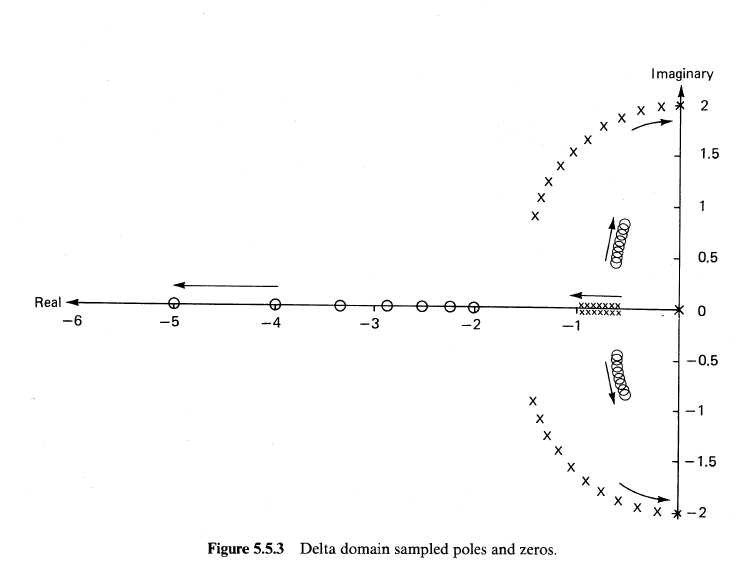

In [2]:
Image(filename='./Figures/d_domain_pz.png')

[Digital Control and Estimation](https://dl.acm.org/doi/10.5555/574885)

## $\Sigma\Delta$ Encoded Pulse Density Modulated Signals

Pulse density modulation is a signal representation in the form of a stream of bits; ones and zeros. The information in an analog signal or a discrete parallel bit word sample (i.e. 2's complement) is contained within the amplitude. For a PDM signal, the information is contained within the density of bits over a finite window of time. 

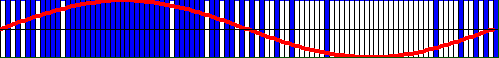

In [4]:
Image(filename='./Figures/PDM.gif')

The power spectral density (PSD) of a PDM signal is the principle representation in which to analyze and characterize a bitstream as its signal and noise power versus frequency. The PSD reveals characteristics about a bitstream such as the signal it is encoding, the quality of the signal, and the distribution of the noise inherent in the representation.

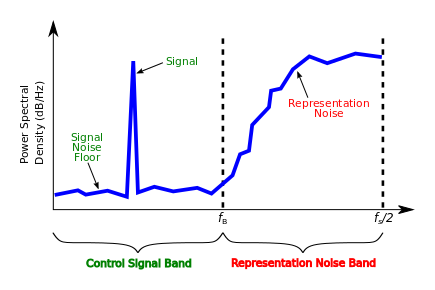

In [5]:
Image(filename='./Figures/PSD.png')

The PSD pictured is that of a PDM encoded discrete sinusoidal signal with a fundemental frequency of $f_{sig}$. The signal component can be seen as a spike at $f_{sig}$. Perhaps the most striking aspect of the PSD is the shape of the noise floor. The noise floor of the signal is flat in the lower frequencies up to $f_{B}$ which corresponds to the input resolution of the encoded discrete signal or noise-floor associated with the input analog signal. (Abstractly, there is no lower bound on the PSD noise at low frequencies if sufficiently large resolution is used). In the higher frequencies, from $f_{B}$ to $f_{s}/2$, the noise floor increases dramatically and saturates the power spectrum. The concentration of noise power in the higher frequencies is a hallmark of PDM signals and is in fact a by-product of the feedback correction nature of the encoder. That is, the high frequency noise is inherent in the representation but is pushed out of the signal band (i.e. frequencies below $f_{B}$) and into the representation noise band (i.e. frequencies above $f_{B}$). The quality of pushing or shaping the representation noise into high frequencies allows PDM bitstreams to achieve a very high quality encoding at the cost of the higher oversampled rate $f_{s}$ versus the desired signal bandwidth $f_{B}$. Since the over-sampled signal is a binary bit-stream, it admits a variety of simple computation mechanisms all operated at the oversampled clock (sample) rate. The large ratio $f_{s}/\left(2f_{B}\right)$ allows for very low noise representation of the desired signal band, while the binary nature of the output admits single threshold (hence very linear) ADC.

[Understanding $\Delta\Sigma$ Data Converters](https://ieeexplore.ieee.org/book/5264508)

## Glossary

- Signal Band: The signal band is the frequency range from DC to $f_{B}$ which signal components can exist without the contamination of high levels of background noise. 
- Representation Noise Band: The representation noise band is the frequency range from $f_{B}$ to $\frac{f_{s}}{2}$ where the representation noise is pushed and dominates the signal spectral density.
- $f_{B}$: The signal bandwidth.
- OSR: The oversample ratio (OSR) is the defined as the ratio between the oversampling frequency $f_{s}$ and the Nyquist frequency
  
  $2f_{B} OSR=\frac{f_{s}}{2f_{B}}$

- SNR: The signal to noise ratio (SNR) is defined as the ratio between the signal power $\mu_{x}^{2}$ and the noise variance $\sigma_{n}^{2}$ in the signal band from DC to $f_{B}$.
- ENOB: The effective number of bits (ENOB) is a measure of how many bits of signal information are contained in the bitstream signal based on given SNR or SINAD. The ENOB can be calculated by
  
  $ENOB=\frac{SINAD-1.76}{6.02}$

# Jupyter Notebooks

These ipython Jupyter notebooks strive to elucidate $\Sigma\Delta$ Stream Computation and make it accessible to a wider audience. The interactive notebooks map the mathematical equations to the implemented python code. Graphs illustrate whats happening under the hood. There are several example designs that walk through the whole process, beginning to end. 

There are just three inputs required to get started
1. Ideal continuous state space model of a controller or filter
2. Frequency band of interest, the useful part of the signal
3. Over sampling ratio (OSR) for the $\Sigma\Delta$ encoded data.

The outputs from the notebooks 
1. Bit accurate structure for the $\Sigma\Delta$ controller / filter
2. Optimized coefficients for the $\Sigma\Delta$ controller / filter
3. Verilog modules with accompanying parameters implementing the bit accurate Sigma\Delta$ controller / filter

# Example Implementations


Several digital filter implementations using $\Sigma\Delta$ stream computation are listed below. The computations are broken up into five steps.

1. Pick a filter to implement
   - Generate a continuous state space model for the filter
2. Convert the continuous state space model into a digitally sampled $\delta\$ domain representation
3. Preform a sensitivity analysis
4. Analyze the noise gain
5. Use the sensitivity and noise gain analysis to calculate the optimal fixed point representations of the coefficients and internal node gains

## Pick a filter to implement

[cheby2 bandpass - 300Hz to 3kHz](./1_cheby2_bandpass.ipynb)


---
---

---
# References
[$\Sigma\Delta$ Stream Computation: A New Paradigm for Low Power and High Resolution Feedback Control](https://escholarship.org/uc/item/4f46n0h6) by Poverelli, Joseph Sam

[Understanding $\Delta\Sigma$ Data Converters](https://ieeexplore.ieee.org/book/5264508) by Richard Schreier & Gabor C. Temes

[Digital Control and Estimation: A Unified Approach](https://dl.acm.org/doi/10.5555/574885) by Richard H Middleton & 
Graham C Goodwin

[A generalized direct-form delta operator-based IIR filter with minimum noise gain and sensitivity](https://ieeexplore.ieee.org/document/933811) by Ngai Wong & Tung-Sang Ng